# MusicBrainz Lab
## Task 2: Exploring genres by music descriptors

In [1]:
import sys, os, csv, json, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import jmespath # pip install jmespath

# Defining all the constants that will be used within the code

SELECTED_DATASET = "tagtraum" # Defining the dataset that will be used
FEATURES_DATASET = "acousticbrainz-mediaeval2017-train-amplab2019-selected-features-mbid.csv"
HIGH_LEVEL_FEATURES_FOLDER = "acousticbrainz-mediaeval-train-intersection-highlevel"

# This is the list of features that will be casted to float
FEATURES_TO_CAST_TO_FLOAT = [
    'lowlevel.average_loudness',
    'metadata.audio_properties.length',
    'metadata.audio_properties.replay_gain',
    'rhythm.bpm',
    'rhythm.danceability',
    'rhythm.onset_rate'
]

LOAD_DATA_FILES = True
LOAD_FEATURES_FILES = True

DATA_FILES_FOLDER = "../Data Files"
OUTPUT_PLOT_FOLDER = "Output Plots"

HIGH_LEVEL_FEATURES_FOLDER_PATH = DATA_FILES_FOLDER + '/' + HIGH_LEVEL_FEATURES_FOLDER

if not os.path.isdir(OUTPUT_PLOT_FOLDER): os.makedirs(OUTPUT_PLOT_FOLDER)
#image_folder = os.path.join()

# Removing a warning from DataFrame
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## 1. Take the four genre datasets and compute the intersection of all of them, based on the recording ID. We provide music features for this intersection.

In [2]:
# This function loads the every recordings for every dataset
def load_datasets(datasets, load_ids_only = False):
    
    # Loading the datasets
    for dataset_name in datasets:
        
        datasets[dataset_name]["recordings"] = load_dataset_recordings(
            dataset_name, datasets[dataset_name]["path"], load_ids_only
        )
    
    print("All datasets have been loaded")
    
    return datasets

# This function loads the recordings of a certain dataset 
def load_dataset_recordings(dataset_name, dataset_path, load_ids_only = False):
    
    print("Loading the \"" + dataset_name + "\" dataset")

    with open(dataset_path) as tsvfile:

        # Reading the TSV's
        recordings = csv.reader(tsvfile, delimiter='\t') 

        # Getting the headers
        dataset_headers = next(recordings)

        # The recordings will be stored here
        dataset_recordings = {}

        for recording in recordings:

            recording_keys = []
            recording_values = []

            # Generating the index and value lists
            for prop_index, prop_value in enumerate(recording):

                recording_keys.append(dataset_headers[prop_index])
                recording_values.append(prop_value)
            
            if (load_ids_only == True):
                # Adding the id's only as a dictionary in the recordings dictionary
                dataset_recordings[recording_values[0]] = {}
            else:
                # Adding the 2 lists correlated as a dictionary in the recordings dictionary
                dataset_recordings[recording_values[0]] = dict(zip(recording_keys, recording_values))
    
    print("The \"" + dataset_name + "\" dataset has been loaded successfully")
    
    return dataset_recordings


In [3]:
# Checking if we must reload the data files
if (LOAD_DATA_FILES):
    
    # Defining the datasets
    datasets = {
        "allmusic": {
            "path": DATA_FILES_FOLDER + '/' + "acousticbrainz-mediaeval2017-allmusic-train.tsv",
            "recordings": {}
        },
        "discogs": {
            "path": DATA_FILES_FOLDER + '/' + "acousticbrainz-mediaeval2017-discogs-train.tsv",
            "recordings": {}
        },
        "lastfm": {
            "path": DATA_FILES_FOLDER + '/' + "acousticbrainz-mediaeval2017-lastfm-train.tsv",
            "recordings": {}
        },
        "tagtraum": {
            "path": DATA_FILES_FOLDER + '/' + "acousticbrainz-mediaeval2017-tagtraum-train.tsv",
            "recordings": {}
        }
    }
    
    # Loading only the id's of the datasets
    datasets = load_datasets(datasets, load_ids_only = True)
    
    # Computign the intersection id's
    intersection_ids = (
        datasets['allmusic']['recordings'].keys() &
        datasets['discogs']['recordings'].keys() &
        datasets['lastfm']['recordings'].keys() &
        datasets['tagtraum']['recordings'].keys()
    )

    # Adding a virtual dataset with the intersected recordings
    datasets["intersection"] = {
        "recordings": dict.fromkeys(intersection_ids, {})
    }


Loading the "lastfm" dataset
The "lastfm" dataset has been loaded successfully
Loading the "discogs" dataset
The "discogs" dataset has been loaded successfully
Loading the "tagtraum" dataset
The "tagtraum" dataset has been loaded successfully
Loading the "allmusic" dataset
The "allmusic" dataset has been loaded successfully
All datasets have been loaded


## 2. Select one genre source you want to use out of four (AllMusic, Discogs, Last.fm, or Tagtraum) and prepare the corresponding subset of the genre and subgenre annotations and the features.

In [4]:
# This function loads the features of the recordings
def load_dataset_recordings_features(dataset_path):

    print("Loading the features dataset")

    with open(dataset_path) as tsvfile:

        # Reading the TSV's
        recordings = csv.reader(tsvfile) 

        # Getting the headers
        dataset_headers = next(recordings)

        # The recordings will be stored here
        dataset_recordings_features = {}

        for recording in recordings:

            recording_features_keys = []
            recording_features_values = []
            
            # Generating the index and value lists
            for feature_index, feature_value in enumerate(recording):
                
                # If the feature must be casted to a float type
                if (dataset_headers[feature_index] in FEATURES_TO_CAST_TO_FLOAT):
                    recording_features_values.append(float(feature_value))
                else:
                    recording_features_values.append(feature_value)
                    
                recording_features_keys.append(dataset_headers[feature_index])

            # Adding the 2 lists correlated as a dictionary in the recordings dictionary
            dataset_recordings_features[recording_features_values[0]] = dict(zip(recording_features_keys, recording_features_values))    
    
    print("The features dataset has been loaded successfully")
    
    return dataset_recordings_features


In [5]:
# Checking if we must reload the data files
if (LOAD_DATA_FILES):
    
    # Loading the recordings values for the "tagtraum" dataset
    all_dataset_recordings = load_dataset_recordings(SELECTED_DATASET, datasets[SELECTED_DATASET]["path"])

    # Keeping only the recordings that are present in the inresection
    datasets[SELECTED_DATASET]['recordings'] = {
        k: all_dataset_recordings[k] for k in datasets['intersection']['recordings'].keys()
    }
    

Loading the "tagtraum" dataset
The "tagtraum" dataset has been loaded successfully


In [6]:
# Checking if we must reload the features files
if (LOAD_FEATURES_FILES):
    
    # Loading the recordings features for the "tagtraum" dataset
    all_features = load_dataset_recordings_features(DATA_FILES_FOLDER + '/' + FEATURES_DATASET)

    print("Embeding the recordings features into the \"" + SELECTED_DATASET + "\" dataset")
    
    for k in datasets[SELECTED_DATASET]['recordings'].keys(): datasets[SELECTED_DATASET]['recordings'][k].update(all_features[k])
    
    print("Features embedded successfully")
    

Loading the features dataset
The features dataset has been loaded successfully
Embeding the recordings features into the "tagtraum" dataset
Features embedded successfully


## 3. Select a set of at least 20 subgenres to work with (or do analysis on all subgenres)
- Subgenres that you personally know or are curious to explore
- Subgenres that are well represented: If you have too many subgenre labels, remove subgenres that occur for less than N recordings (for example, N=200, or decide your own threshold).
- Select at least a few subgenres per genre to cover different types of music in your analysis

In [7]:
# I have tried to not choose only electronic ones in order to get more diverse results

# I am personally curious about this 25 subgenres
subgenres = {
    "dubstep---bass": {},
    "electronic---ambient": {},
    "electronic---elektro": {},
    "electronic---downtempo": {},
    "electronic---glitchhop": {},
    "dance---house": {},
    "dubstep---grime": {},
    "jazz---jazzfusion": {},
    "jazz---jazzpiano": {},
    "world---indian": {},
    "world---traditional": {},
    "world---african": {},
    "soundtrack---ost": {},
    "soundtrack---filmsoundtrack": {},
    "soundtrack---score": {},
    "country---countrypop": {},
    "country---classiccountry": {},
    "country---americana": {},
    "hiphop---raphiphop": {},
    "hiphop---gangstarap": {},
    "hiphop---instrumentalhiphop": {},
    "rock/pop---classicrock": {},
    "rock/pop---hardrock": {},
    "rock/pop---metal": {},
    "rock/pop---pop": {}
}

In [8]:
# Deleting the recordings that do not have any of the desired subgenres (we use a copy to iterate over it)
for recording_id, recording in datasets[SELECTED_DATASET]['recordings'].copy().items():
    
    subgenre_found = False

    for feature_name, feature_value in recording.items():

        if feature_name.startswith('genre') & (feature_value in subgenres): subgenre_found = True

    if not subgenre_found: del datasets[SELECTED_DATASET]['recordings'][recording_id]
        

### <font color=red>Warning:</font> loading the high level features, this process can take up to 15 minutes depending on your CPU

In [9]:
# Now we will anticipate one step for the section 6, before doing the subset of subgenres for the
# next section 3 we will embed the high level features in advance
selected_hl_features = [ "happy", "sad", "relaxed", "aggressive", "party", "male", "female", "voice", "instrumental", "danceable"]

# Time tic
tic = time.time()

# Total number of folders
number_of_folders = len(os.listdir(HIGH_LEVEL_FEATURES_FOLDER_PATH))


# Iterating over the high level features folders
for folder_i, folder in enumerate(sorted(os.listdir(HIGH_LEVEL_FEATURES_FOLDER_PATH))):
    
    print("Processing high level features batch \"" + folder + "\" [" + str(folder_i + 1) + "/" + str(number_of_folders) + "]")
    
    files = (f for f in os.listdir(HIGH_LEVEL_FEATURES_FOLDER_PATH + '/' + folder) if f.endswith('.json'))
    
    for file in files:
        
        # print("File: ", file)
        
        recording_id, file_extension = os.path.splitext(file)
        
        if recording_id in datasets[SELECTED_DATASET]['recordings']:
            
            # print(file_name)

            with open(HIGH_LEVEL_FEATURES_FOLDER_PATH + '/' + folder + '/' + file) as json_file:
                
                json_dict = json.load(json_file)
                    
                for selected_hl_feature in selected_hl_features:
                    
                    selected_hl_feature_value = jmespath.search('highlevel.*.all[].' + selected_hl_feature + " | [0]", json_dict)
                    
                    datasets[SELECTED_DATASET]['recordings'][recording_id].update({
                        selected_hl_feature: selected_hl_feature_value
                    })       

print("The high level features dataset has been loaded successfully")

# Time toc
toc = time.time()

# Displaying total time
print("The process took " + time.strftime("%H:%M:%S", time.gmtime(toc - tic)) + " to complete")
    

Processing high level features batch "00" [1/256]
Processing high level features batch "01" [2/256]
Processing high level features batch "02" [3/256]
Processing high level features batch "03" [4/256]
Processing high level features batch "04" [5/256]
Processing high level features batch "05" [6/256]
Processing high level features batch "06" [7/256]
Processing high level features batch "07" [8/256]
Processing high level features batch "08" [9/256]
Processing high level features batch "09" [10/256]
Processing high level features batch "0a" [11/256]
Processing high level features batch "0b" [12/256]
Processing high level features batch "0c" [13/256]
Processing high level features batch "0d" [14/256]
Processing high level features batch "0e" [15/256]
Processing high level features batch "0f" [16/256]
Processing high level features batch "10" [17/256]
Processing high level features batch "11" [18/256]
Processing high level features batch "12" [19/256]
Processing high level features batch "13

Processing high level features batch "a0" [161/256]
Processing high level features batch "a1" [162/256]
Processing high level features batch "a2" [163/256]
Processing high level features batch "a3" [164/256]
Processing high level features batch "a4" [165/256]
Processing high level features batch "a5" [166/256]
Processing high level features batch "a6" [167/256]
Processing high level features batch "a7" [168/256]
Processing high level features batch "a8" [169/256]
Processing high level features batch "a9" [170/256]
Processing high level features batch "aa" [171/256]
Processing high level features batch "ab" [172/256]
Processing high level features batch "ac" [173/256]
Processing high level features batch "ad" [174/256]
Processing high level features batch "ae" [175/256]
Processing high level features batch "af" [176/256]
Processing high level features batch "b0" [177/256]
Processing high level features batch "b1" [178/256]
Processing high level features batch "b2" [179/256]
Processing h

## 4. Compare the selected subgenres in terms of the distribution of their music features:
- BPM (beats per minute) - rhythm.bpm
- Onset rate (number of detected onsets per second) - rhythm.onset_rate
- Danceability (from 0 to 3; higher values meaning more danceable) - rhythm.danceability
- Loudness (replay gain) - metadata.audio_properties.replay_gain
- Track duration - metadata.audio_properties.length
- Year - metadata.tags.date or metadata.tags.original_date

In [10]:
# Selected features
selected_features = [
    "rhythm.bpm",
    "rhythm.onset_rate",
    "rhythm.danceability",
    "metadata.audio_properties.replay_gain",
    "metadata.audio_properties.length",
    "tonal.key_key",
    "tonal.key_scale",
]

In [11]:
# Processed subgenres
processed_subgenres = 0

# Averaging the selected features and the selected high level for every subgenre
for subgenre in subgenres:
    
    print("Processing subgenre \"" + subgenre + "\" [" + str(processed_subgenres + 1) + "/" + str(len(subgenres)) + "]")

    # Initializing subgenre dictionary
    subgenres[subgenre] = {}

    # Initializing subgenre variables
    subgenres[subgenre]["number_of_recordings"] = 0

    for recording_id, recording in datasets[SELECTED_DATASET]['recordings'].items():

        # Initializing variables
        subgenre_found = False

        for feature_name, feature_value in recording.items():

            # If the subgenre has already been found it's not necessary to keep iterating
            if (not subgenre_found) & feature_name.startswith('genre') & (feature_value == subgenre):

                subgenre_found = True

        if (subgenre_found):

            subgenres[subgenre]["number_of_recordings"]+=1

            for selected_feature in (selected_features + selected_hl_features):

                # If this feature is present in this recording 
                if selected_feature in recording:
                
                    # If the feature does not exist we will create it
                    if (subgenres[subgenre]["number_of_recordings"] <= 1):
                        subgenres[subgenre][selected_feature] = {}
                        subgenres[subgenre][selected_feature]["all"] = {
                            recording[selected_feature]
                        }
                    # Otherwise we will simply keep adding values
                    else:
                        subgenres[subgenre][selected_feature]["all"].update({
                            recording[selected_feature]
                        })

    # Once the subgenre has all the features we will average them
    for selected_feature in (selected_features + selected_hl_features):

        # If the feature has a dictionary called "all"
        if (subgenres[subgenre][selected_feature]["all"]):
            
            # AN it is a float type
            if (selected_feature in FEATURES_TO_CAST_TO_FLOAT):
                
                subgenres[subgenre][selected_feature]["average"] = sum(subgenres[subgenre][selected_feature]["all"]) / subgenres[subgenre]["number_of_recordings"]
            
    processed_subgenres+=1
                
print("All the subgenres were processed successfully")


Processing subgenre "rock/pop---pop" [1/25]
Processing subgenre "rock/pop---classicrock" [2/25]
Processing subgenre "electronic---downtempo" [3/25]
Processing subgenre "electronic---glitchhop" [4/25]
Processing subgenre "dubstep---bass" [5/25]
Processing subgenre "world---african" [6/25]
Processing subgenre "country---classiccountry" [7/25]
Processing subgenre "hiphop---raphiphop" [8/25]
Processing subgenre "electronic---elektro" [9/25]
Processing subgenre "dance---house" [10/25]
Processing subgenre "hiphop---gangstarap" [11/25]
Processing subgenre "rock/pop---hardrock" [12/25]
Processing subgenre "electronic---ambient" [13/25]
Processing subgenre "soundtrack---filmsoundtrack" [14/25]
Processing subgenre "world---traditional" [15/25]
Processing subgenre "soundtrack---ost" [16/25]
Processing subgenre "world---indian" [17/25]
Processing subgenre "country---americana" [18/25]
Processing subgenre "jazz---jazzfusion" [19/25]
Processing subgenre "country---countrypop" [20/25]
Processing subg

In [12]:
# Displaying a comparative table
df_subgenres = pd.DataFrame(subgenres)

features_aux = df_subgenres.index.tolist()

features_to_keep = [x for x in features_aux if ( (x in selected_features) & (x in FEATURES_TO_CAST_TO_FLOAT))]
features_to_drop = [x for x in features_aux if x not in features_to_keep]

# Droping the features that are not on the "selected_features" list
df_subgenres = df_subgenres.drop(features_to_drop, axis=0)

average_dict = {}

# Getting he average as the cell display
for subgenre in df_subgenres:
    
    df_aux = df_subgenres[subgenre].apply(pd.Series)
    average_dict[subgenre] = df_aux["average"].tolist()

# Formatting the table
df_average = pd.DataFrame(average_dict)
df_average = df_average.set_index([features_to_keep]).transpose()
df_average

,metadata.audio_properties.length,metadata.audio_properties.replay_gain,rhythm.bpm,rhythm.danceability,rhythm.onset_rate
country---americana,214.360379,-9.897646,121.197284,1.084484,3.419090
country---classiccountry,177.248093,-8.543168,120.119803,1.098178,3.570131
country---countrypop,208.203243,-9.602379,122.077445,1.076461,3.464213
dance---house,283.369478,-11.031171,123.394262,1.385022,4.678059
dubstep---bass,277.793042,-11.829162,123.853770,1.218626,4.419573
dubstep---grime,287.750023,-11.467484,123.927158,1.247699,4.502031
electronic---ambient,313.154021,-8.787659,119.286192,1.210691,3.563086
electronic---downtempo,290.851149,-9.718127,118.327600,1.243545,3.987765
electronic---elektro,269.598563,-11.449572,123.054825,1.340959,4.396431
electronic---glitchhop,283.333519,-12.583016,112.174456,1.231754,4.181886


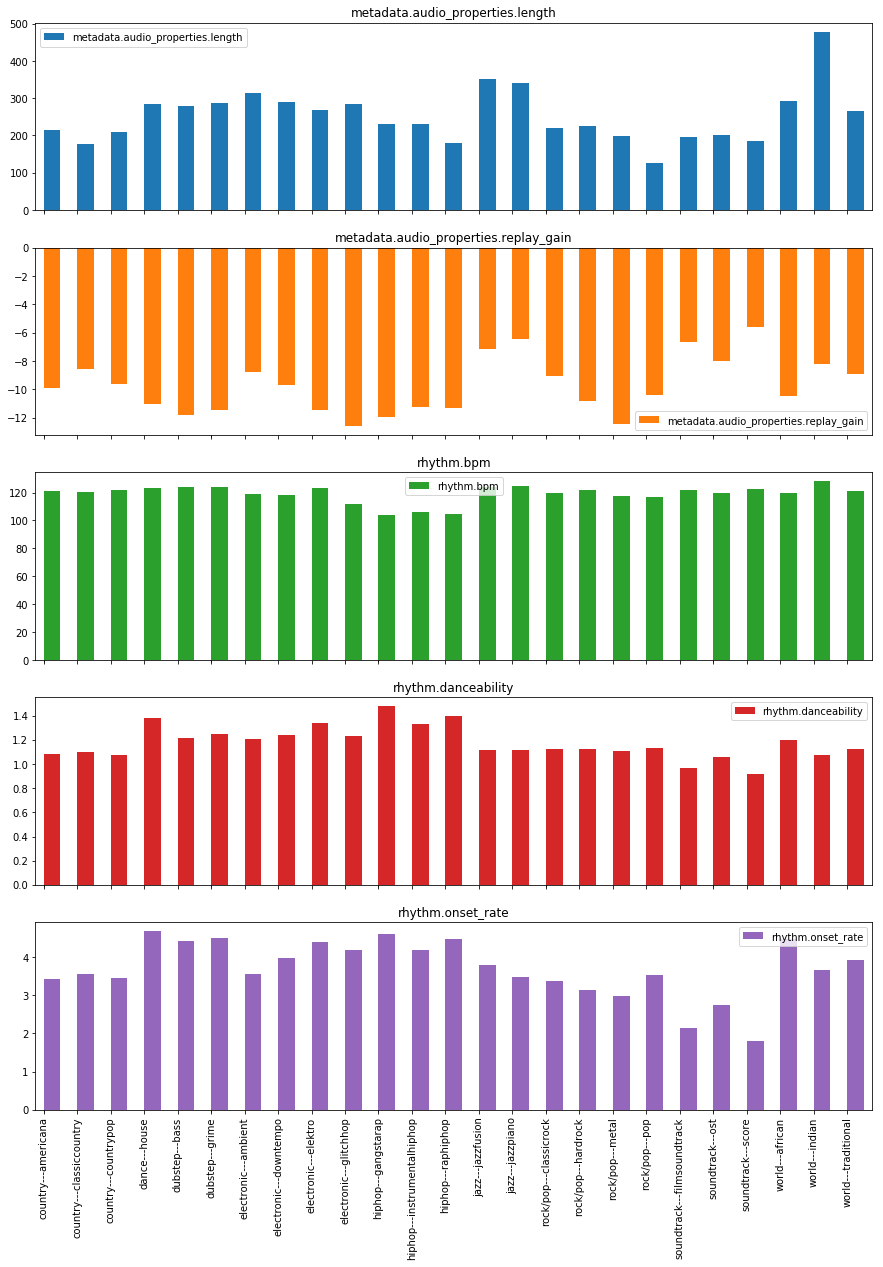

In [13]:
# Displaying a comparative graph
df_average.plot.bar(subplots = True, figsize = (15,20), rot = 90, position = 0)
plt.savefig(OUTPUT_PLOT_FOLDER + "/subgenres_comparative_graph", dpi=100)
plt.show()

## 5. To this end, make comparative plots of the distributions of the feature values for each subgenre
- As an example, in the case of duration, your plots can look similar to the duration boxplots here (whiskers are set at 5% and 95% to see the overall range in tracks duration).
- In the case of key/scale you may want to use histograms of key-scale combinations or separate histograms for key and scale

In [14]:
# Fucntion to plot Box Plots
def box_plot(subgenres, feature_name):
    
    # Initializing figure
    fig, ax = plt.subplots()
    
    # Figure title
    ax.set_title(feature_name)
    
    values_to_plot = []
    feature_names = []
    
    # Iterating over sobgenres
    for subgenre in subgenres:
        
        values_to_plot.append(list(subgenres[subgenre][feature_name]["all"]))
        feature_names.append(subgenre)

    # Drawing plots
    ax.boxplot(values_to_plot, labels = feature_names, vert = False)

    # Saving plot into a file
    file_name = feature_name.rsplit("_",1)[-1].split(".")[0] + "_box_plot"
    fig.set_size_inches(15,10)
    plt.savefig(OUTPUT_PLOT_FOLDER + "/" + file_name, dpi=100)
    plt.show()

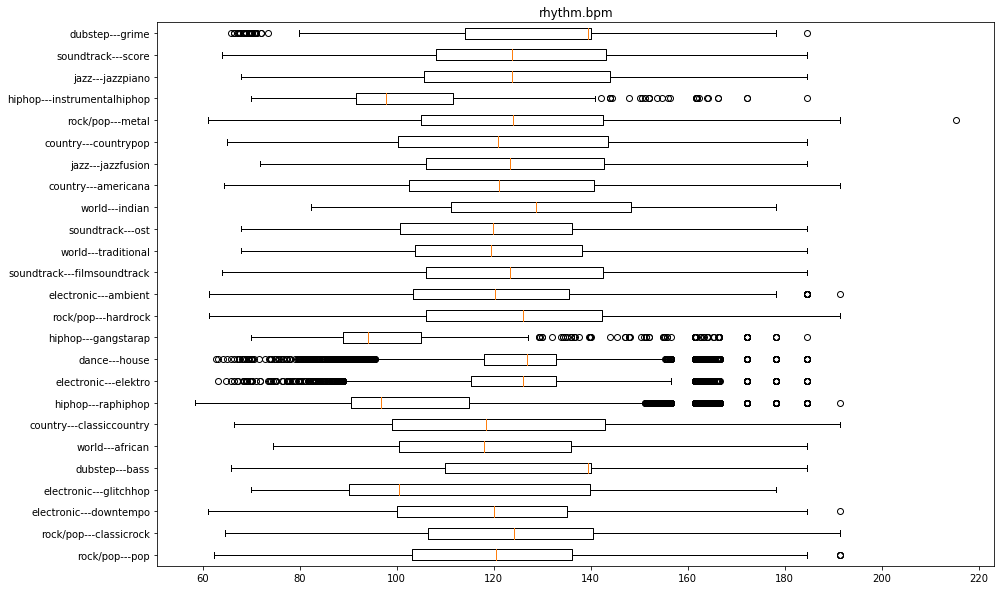

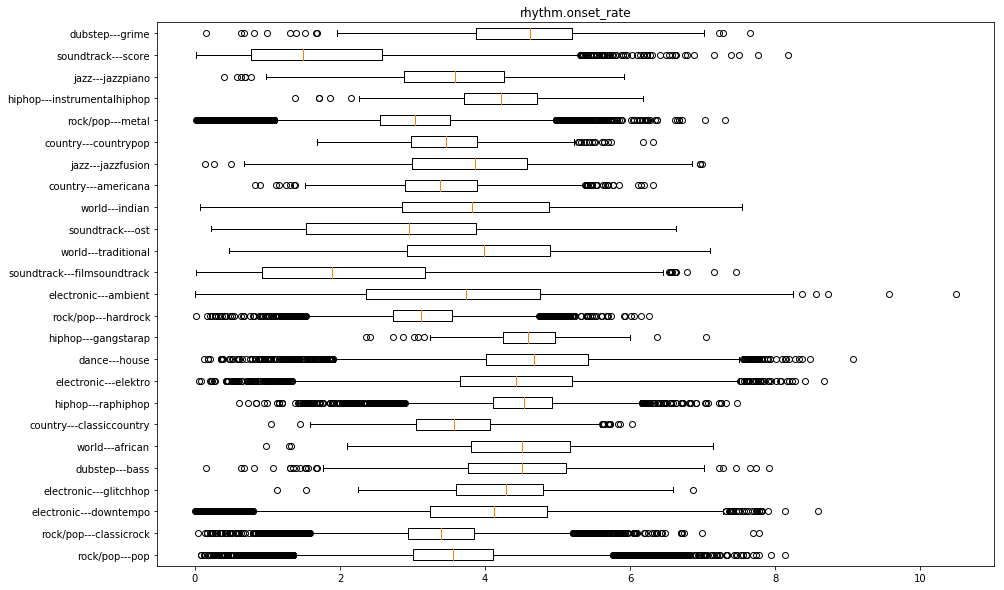

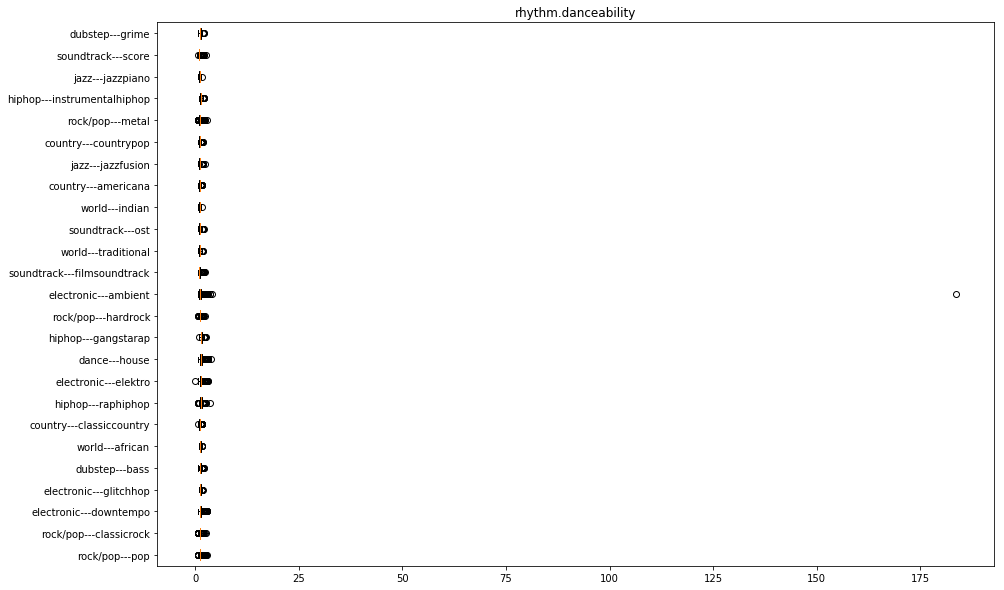

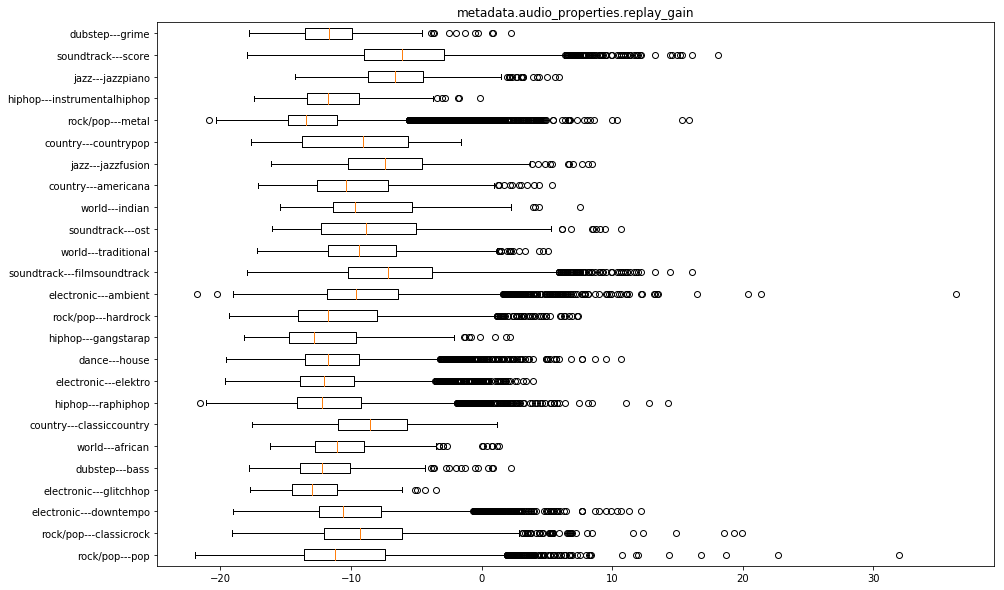

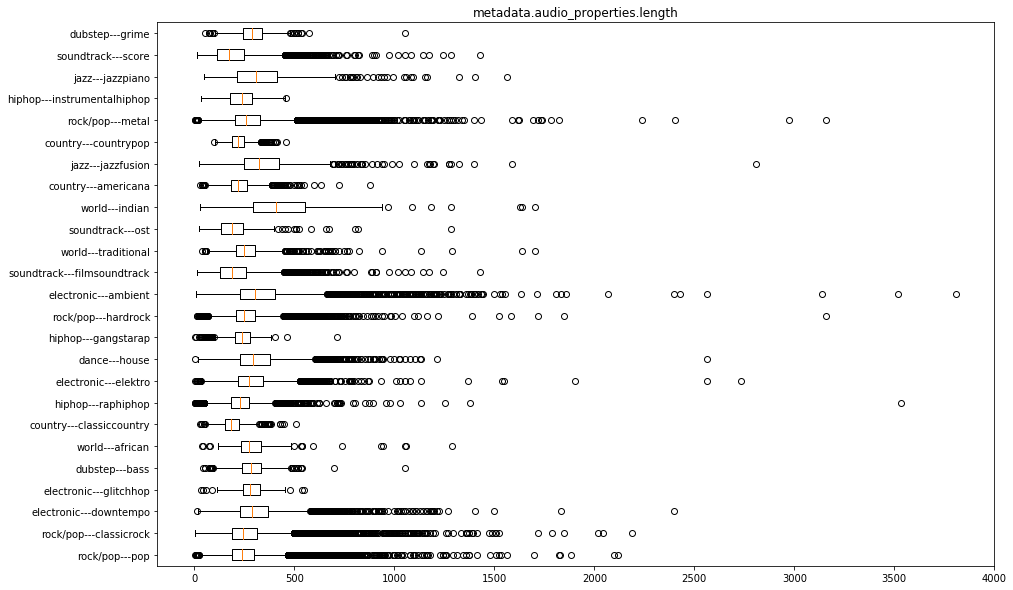

In [15]:
# Numeric and Alphanumeric data
numeric_selected_features = [feature for feature in selected_features if feature in FEATURES_TO_CAST_TO_FLOAT]
alphanumeric_selected_features = [feature for feature in selected_features if feature not in numeric_selected_features]

# For each numeric selected feature
for selected_feature in numeric_selected_features:
    
    # Draw a box plot
    box_plot(subgenres, selected_feature)

# 6. Repeat the process analyzing high-level (classifier based) music features we provide (again, you can use boxplots):
- Plot correlations of music mood estimations (happy, sad, relaxed, aggressive, party) to subgenres.
- Plot correlations of vocal/instrumental, male/female voice, danceability classifier estimations to subgenres.

In [16]:
# Displaying the selected high level features
selected_hl_features

['happy',
 'sad',
 'relaxed',
 'aggressive',
 'party',
 'male',
 'female',
 'voice',
 'instrumental',
 'danceable']

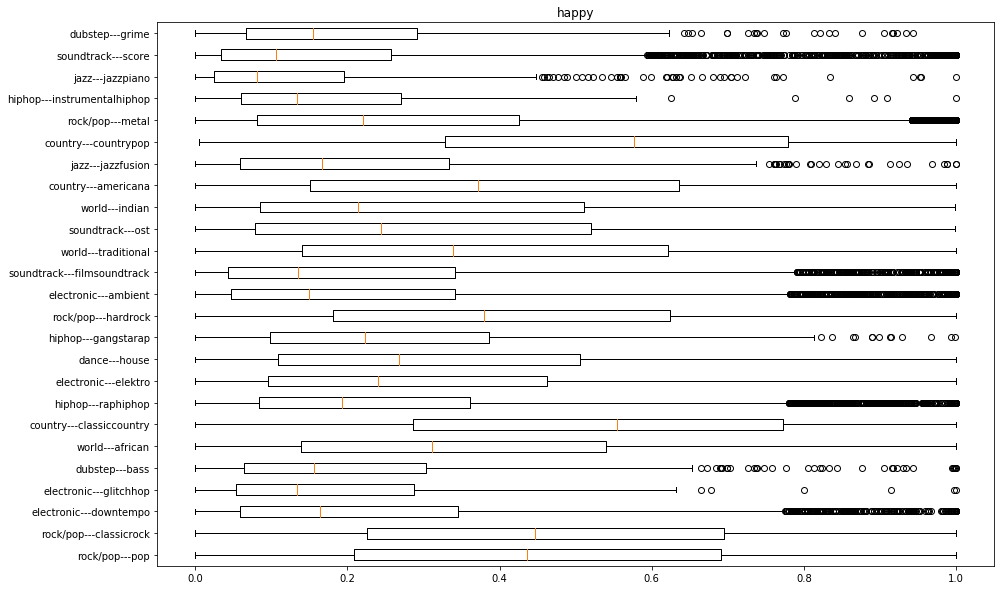

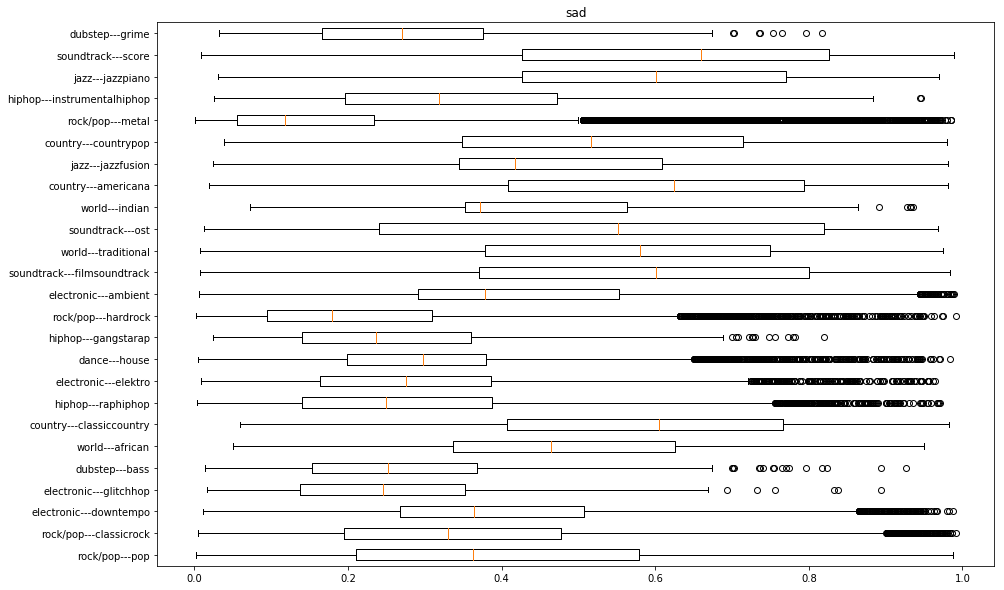

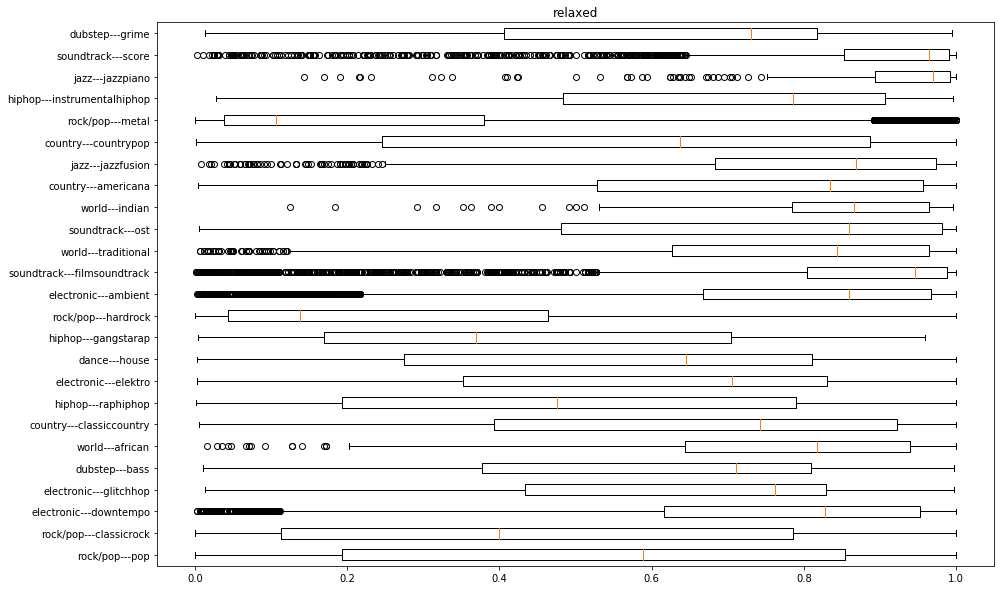

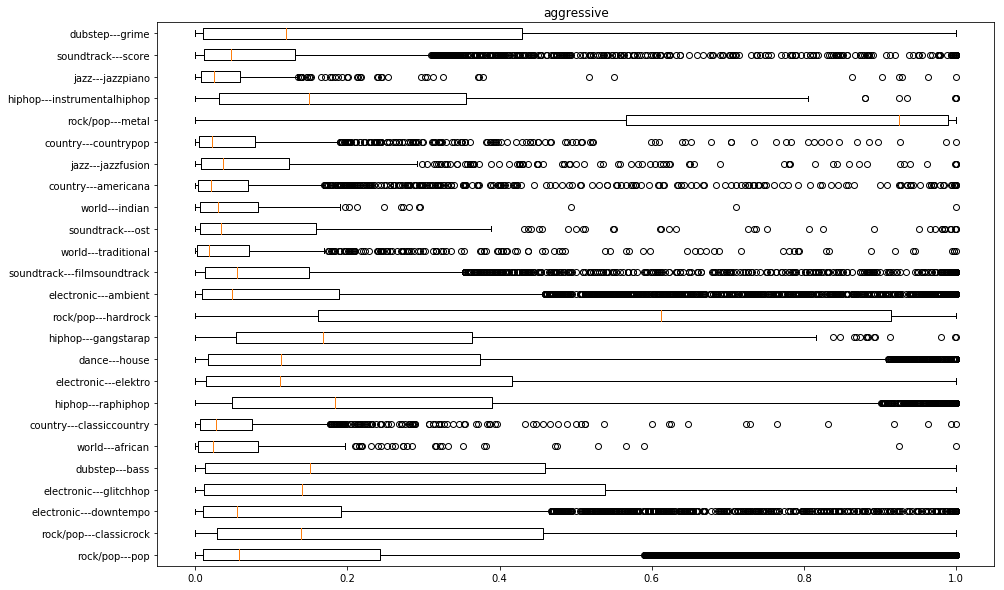

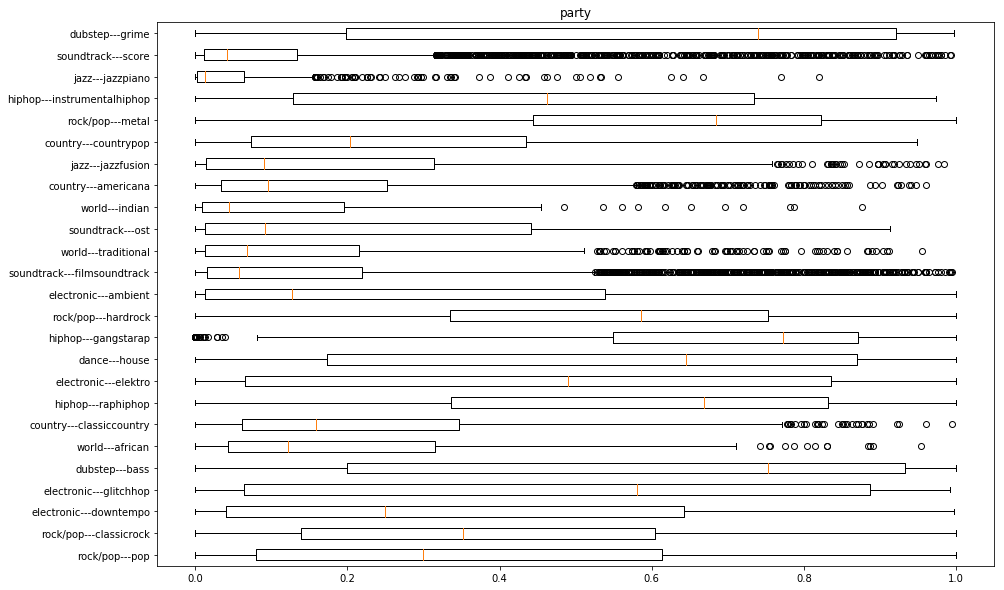

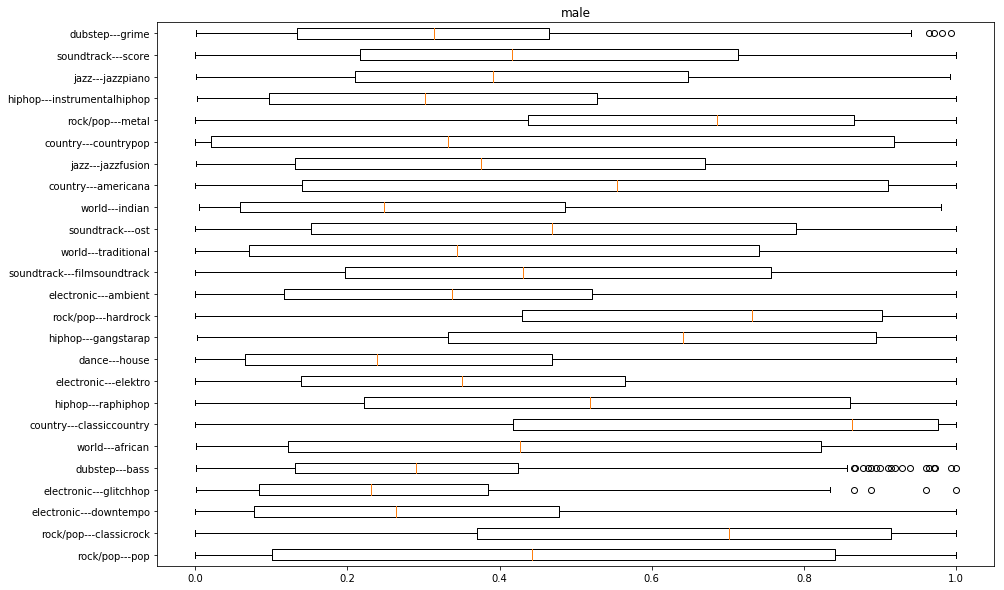

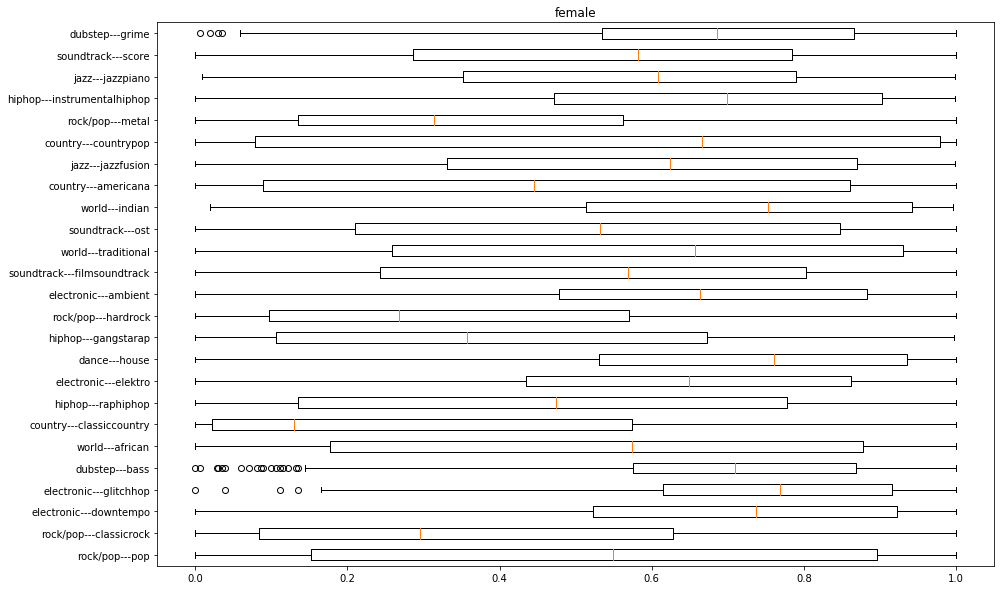

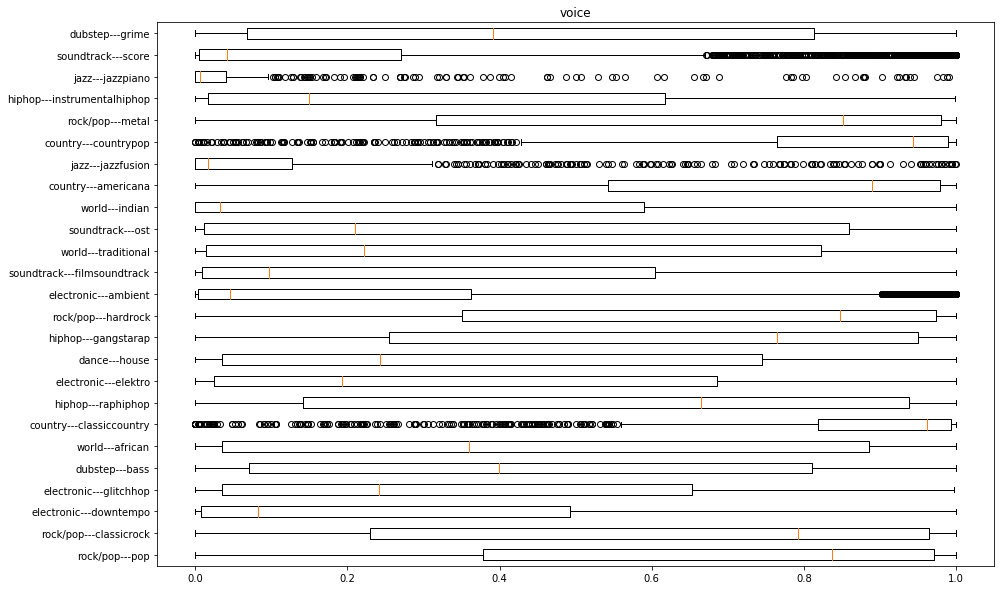

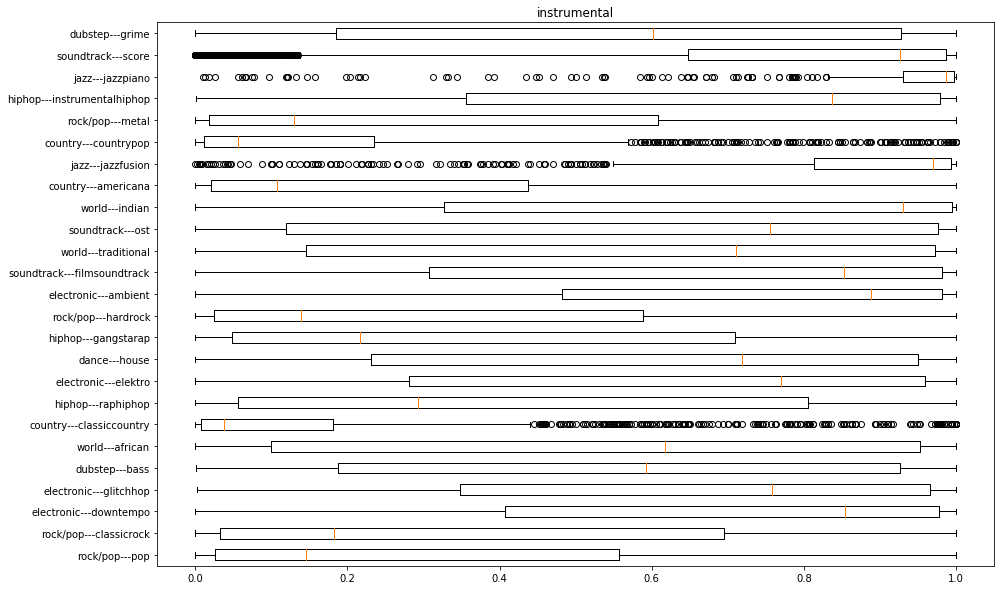

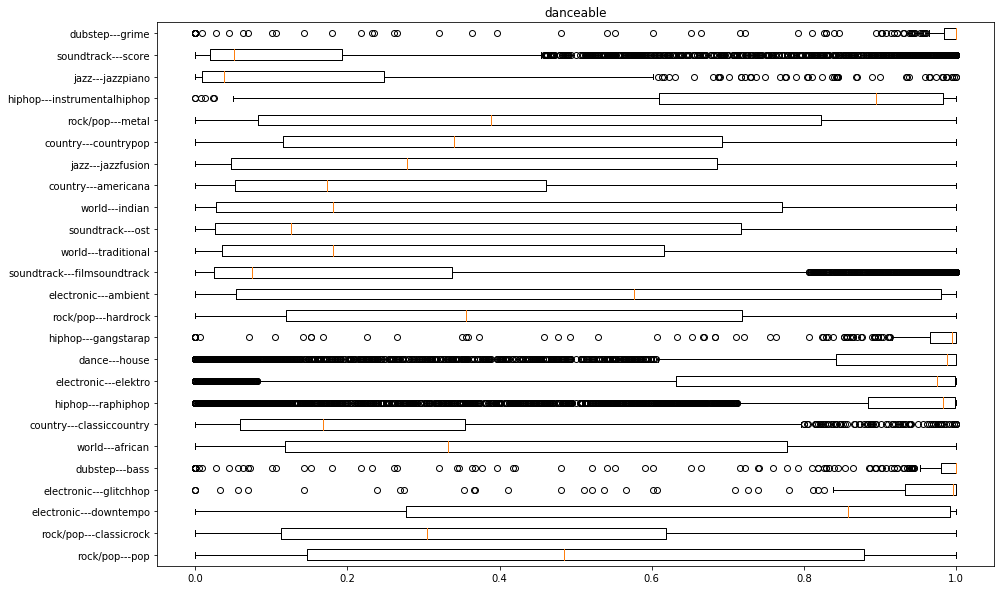

In [17]:
# For each selected feature
for selected_hl_feature in selected_hl_features:
    
    # Draw a box plot
    box_plot(subgenres, selected_hl_feature)